In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lid_driven_cavity import operators, states, postprocessing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=2000, threshold=5000, precision=6)

Parameters

In [3]:
# Physics parameter
# Res = [100, 400, 1000, 3200, 5000]
Re = 5000

# Spatial resolution
N = 20  # number of cells in each direction
h = 1.0 / N

# Temporal resolution
k = 0.1  # FIXME arbitrary for now, likely will need to decrease
n = 0
tn = 0

# Numerical parameters
max_n = 100
tol = 1e-3

n = 0


/home/bzastrow/cfd/project/lid_driven_cavity/src/lid_driven_cavity/postprocessing.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  relative_error = absolute_error / sp.linalg.norm(x_analytical, ord="fro")


dphi = inf


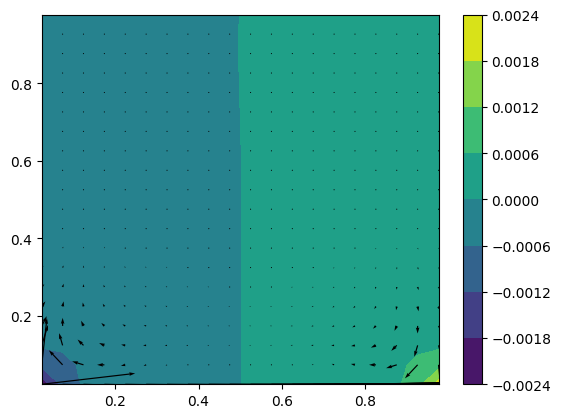

n = 1
dphi = 2.63029e+00


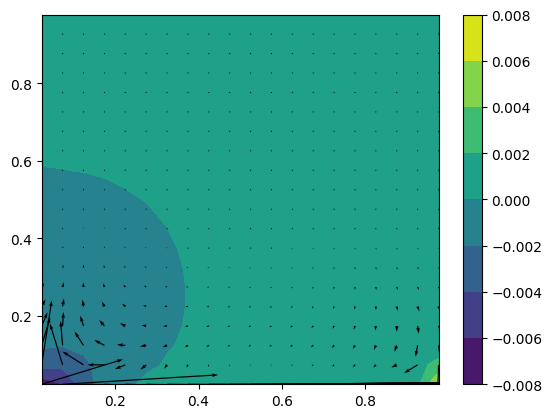

n = 2
dphi = 7.47060e+00


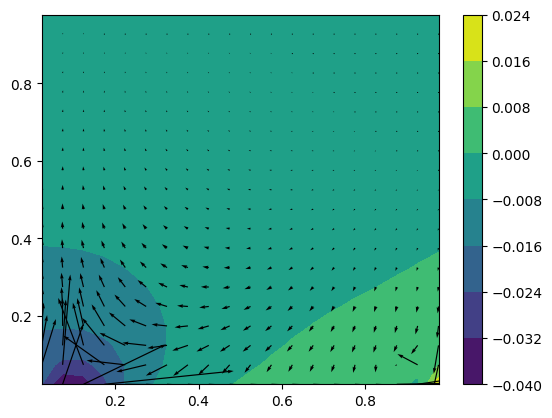

n = 3
dphi = 3.18503e+00


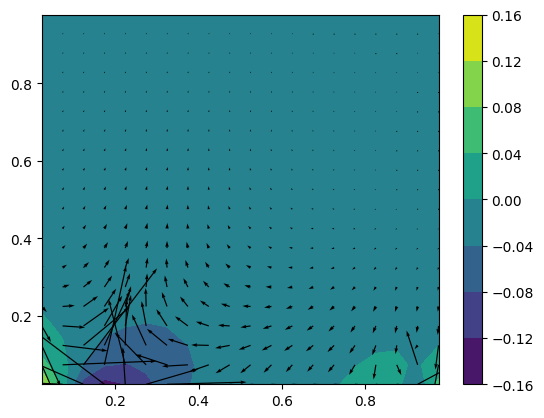

n = 4
dphi = 3.29095e+00


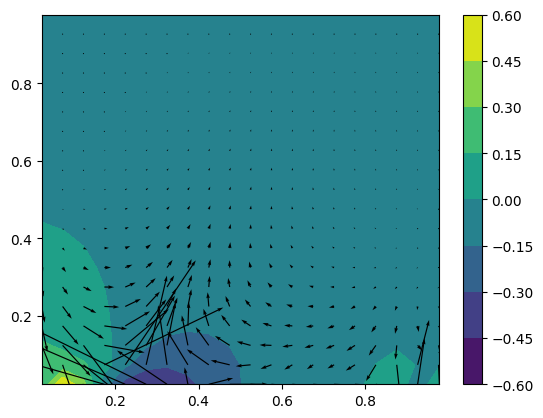

n = 5
dphi = 3.17823e+00


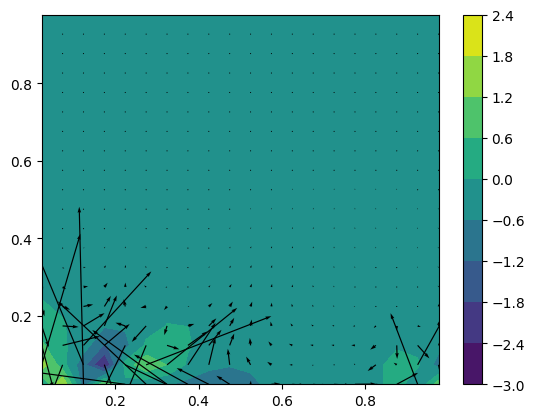

n = 6
dphi = 2.79452e+02


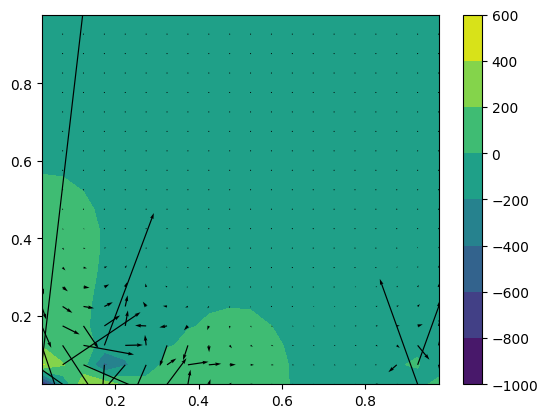

n = 7
dphi = 6.06897e+04


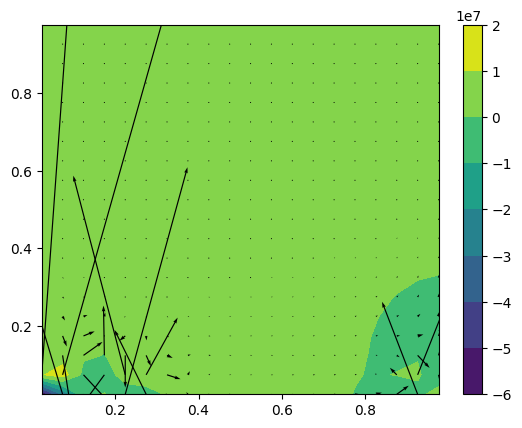

n = 8
dphi = 2.58788e+09


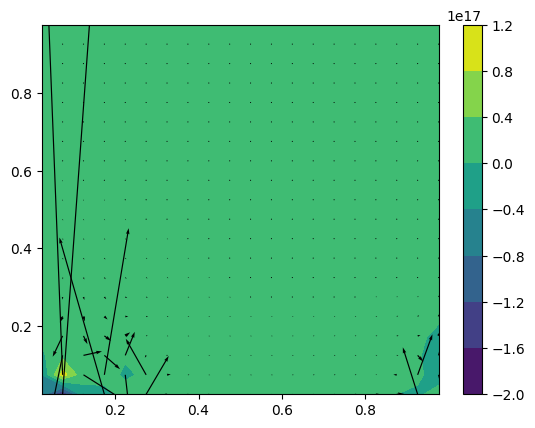

n = 9
dphi = 9.20087e+18


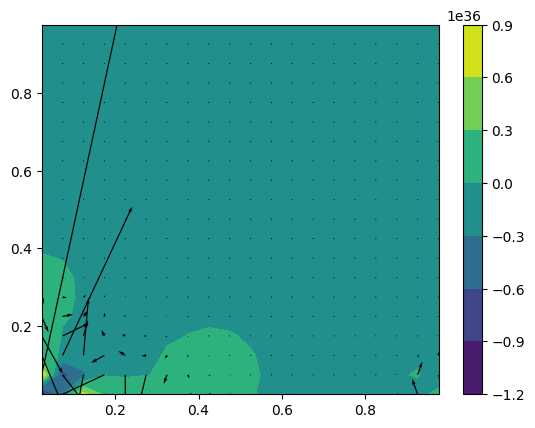

n = 10
dphi = 2.00781e+38


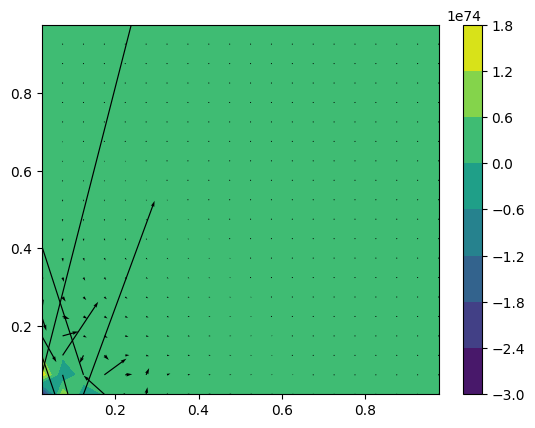

n = 11
dphi = 2.18432e+76


/home/bzastrow/cfd/project/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/iterative.py:652: RuntimeWarning: invalid value encountered in scalar divide
  ptol = Mb_nrm2 * min(ptol_max_factor, atol / bnrm2)


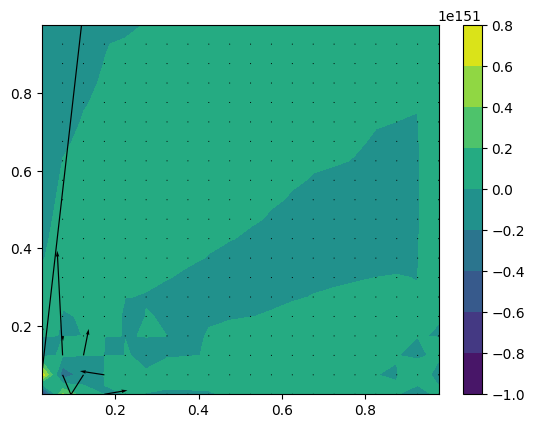

n = 12
dphi = inf


/home/bzastrow/cfd/project/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/iterative.py:715: RuntimeWarning: invalid value encountered in scalar divide
  ptol = presid * min(ptol_max_factor, atol / resid)


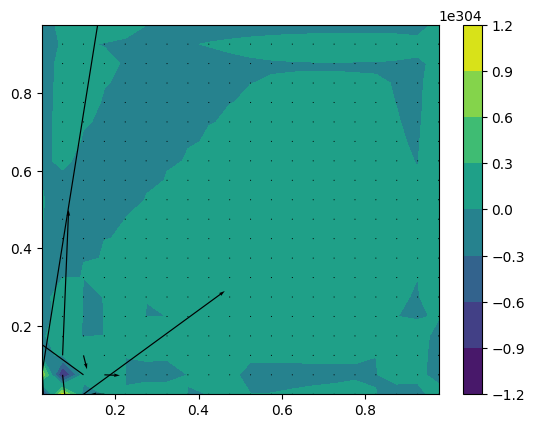

n = 13


/home/bzastrow/cfd/project/lid_driven_cavity/src/lid_driven_cavity/operators.py:159: RuntimeWarning: overflow encountered in multiply
  Nu_interior = (-u_n_interior*dudx - v_hat_interpolated*dudy) / (2*h)
/home/bzastrow/cfd/project/lid_driven_cavity/src/lid_driven_cavity/operators.py:159: RuntimeWarning: invalid value encountered in subtract
  Nu_interior = (-u_n_interior*dudx - v_hat_interpolated*dudy) / (2*h)
/home/bzastrow/cfd/project/lid_driven_cavity/src/lid_driven_cavity/operators.py:182: RuntimeWarning: overflow encountered in multiply
  Nv_interior = (-v_n_interior*dvdx - u_hat_interpolated*dvdy) / (2*h)
/home/bzastrow/cfd/project/lid_driven_cavity/src/lid_driven_cavity/operators.py:182: RuntimeWarning: invalid value encountered in subtract
  Nv_interior = (-v_n_interior*dvdx - u_hat_interpolated*dvdy) / (2*h)


ValueError: array must not contain infs or NaNs

In [4]:
# 1. Assume phi_n, u_n, v_n are known at all points
phi_n = np.zeros((N+2, N+2))
u_n = np.zeros((N+2, N+1))
v_n = np.zeros((N+1, N+2))

# 2. Assume Gx_phi_n, Gy_phi_n are known at all points
Gx_phi_n = operators.compute_gradient_x(phi_n)
Gy_phi_n = operators.compute_gradient_y(phi_n)

# 3. Assume Nu_nm1, Nv_nm1 are known at interior points
Nu_nm1 = np.zeros((N+2, N-1+2))
Nv_nm1 = np.zeros((N-1+2, N+2))

for n in range(max_n):
    print(f"n = {n:d}")

    # ----- Prediction step -----

    # 4. Compute u_hat_n, v_hat_n at interior points
    u_hat_n = operators.compute_interpolated_x(u_n)
    v_hat_n = operators.compute_interpolated_y(v_n)

    # 5. Compute Nu, Nv at interior points
    Nu = operators.compute_Nu(u_n, v_hat_n, h)
    Nv = operators.compute_Nv(v_n, u_hat_n, h)

    # 7. Solve for u_star at all points
    
    # Compute explicit Laplacian
    Lu = operators.compute_laplace(u_n)

    # Assemble RHS
    b_interior_u = (k/2) * (3*Nu.get_matrix()-Nu_nm1.get_matrix()) + u_n.get_matrix() + (k/2)*(1/Re)*Lu.get_matrix()
    b_interior_u = states.strip_boundaries(b_interior_u)

    # pad with zeros on boundaries
    b_u = np.zeros((b_interior_u.shape[0]+2, b_interior_u.shape[1]+2))
    b_u[1:-1, 1:-1] = b_interior_u

    # convert to vector
    b_u = states.matrix_to_vector(b_u)

    # Assemble operator
    # TODO separate assemble...() into a basic (full) laplace operator and a functionality to edit for BCs
    laplacian, b = operators.assemble_laplacian_operator_u(b_u, Nx=N+1, Ny=N+2, h=h)

    # Assemble linear system
    A1 = sp.sparse.eye(laplacian.shape[0], dtype=float, format='csr')
    A2 = (k/2)*(1/Re)*laplacian.get_csr()
    A = A1 - A2

    # Solve implicit step
    u_star = sp.sparse.linalg.spsolve(A, b)
    u_star = states.State(u_star, Nx=N+1, Ny=N+2)

    # Compute explicit Laplacian
    Lv = operators.compute_laplace(v_n)

    # Assemble RHS
    b_interior_v = (k/2) * (3*Nv.get_matrix()-Nv_nm1.get_matrix()) + v_n.get_matrix() + (k/2)*(1/Re)*Lv.get_matrix()
    b_interior_v = states.strip_boundaries(b_interior_v)

    # pad with zeros on boundaries
    b_v = np.zeros((b_interior_v.shape[0]+2, b_interior_v.shape[1]+2))
    b_v[1:-1, 1:-1] = b_interior_v

    # convert to vector
    b_v = states.matrix_to_vector(b_v)

    # Assemble operator
    # TODO separate assemble...() into a basic (full) laplace operator and a functionality to edit for BCs
    laplacian, b = operators.assemble_laplacian_operator_v(b_v, Nx=N+2, Ny=N+1, h=h)

    # Assemble linear system
    A1 = sp.sparse.eye(laplacian.shape[0], dtype=float, format='csr')
    A2 = (k/2)*(1/Re)*laplacian.get_csr()
    A = A1 - A2

    # Solve implicit step
    v_star = sp.sparse.linalg.spsolve(A, b)
    v_star = states.State(v_star, Nx=N+2, Ny=N+1)  # 5, 4

    # ----- Poisson problem -----

    # 8. Compute D(u_star) at interior points
    u_star_matrix = u_star.get_matrix()
    v_star_matrix = v_star.get_matrix()

    # TODO refactor and verify order of convergence
    dudx = u_star_matrix[:, 1:] - u_star_matrix[:, :-1]
    dvdy = v_star_matrix[1:, :] - v_star_matrix[:-1, :]

    dudx_interior = dudx[1:-1, :]
    dvdy_interior = dvdy[:, 1:-1]

    Dstar = (dudx_interior + dvdy_interior) / h

    # 9. Solve for phi_np1 for all interior and ghost points

    b_interior = Dstar / k

    # pad with zeros
    b = np.zeros((b_interior.shape[0]+2, b_interior.shape[1]+2))
    b[1:-1, 1:-1] = b_interior

    # convert to vector
    b = states.matrix_to_vector(b)

    # TODO add ones on main diagonal for state_ij = 0 entries!!!
    Lphi, b = operators.assemble_laplacian_operator_phi(b, u_star_matrix, v_star_matrix, Nx=N+2, Ny=N+2, h=h, k=k)
    A = Lphi.get_csr()

    # phi_np1 = sp.sparse.linalg.spsolve(A, b)
    phi_np1 = sp.sparse.linalg.gmres(A, b)
    phi_np1 = states.State(phi_np1[0], Nx=N+2, Ny=N+2)

    # ----- Correction step -----

    # 10. Compute Gx_phi_np1, Gy_phi_np1 at all points
    Gx_phi_np1 = operators.compute_gradient_x(phi_np1)
    Gy_phi_np1 = operators.compute_gradient_y(phi_np1)

    # 11. Correct u_star to get u_np1 at all points
    u_star_matrix = u_star.get_matrix()
    Gx_phi_np1_matrix = Gx_phi_np1.get_matrix()
    Gx_phi_np1_matrix = Gx_phi_np1_matrix[:, 1:]

    v_star_matrix = v_star.get_matrix()
    Gy_phi_np1_matrix = Gy_phi_np1.get_matrix()
    Gy_phi_np1_matrix = Gy_phi_np1_matrix[:-1, :]

    u_np1_matrix = u_star_matrix - k * Gx_phi_np1_matrix
    v_np1_matrix = v_star_matrix - k * Gy_phi_np1_matrix

    # ----- Bookkeeping -----

    # Compute relative change in phi solution since last iteration (timestep)
    dphi = postprocessing.relative_frobenius_error(phi_np1.get_matrix(), phi_n.get_matrix())
    print(f"dphi = {dphi:.5e}")

    # Update time
    n = n + 1
    tn = tn + k

    # Update states
    phi_n = states.State(phi_np1.vector, Nx=phi_n.Nx, Ny=phi_n.Ny)
    u_n = states.State(u_np1_matrix, Nx=u_n.Nx, Ny=u_n.Ny)
    v_n = states.State(v_np1_matrix, Nx=v_n.Nx, Ny=v_n.Ny)

    postprocessing.plot_streamlines(u_n, v_n, phi_n)

    # Update gradients
    Gx_phi_n = Gx_phi_np1
    Gy_phi_n = Gy_phi_np1

    # Update storage of prior convective (nonlinear) operator action outputs
    Nu_nm1 = Nu
    Nv_nm1 = Nv

    # Check for converged solution
    if dphi < tol:
        break

In [ ]:
postprocessing.plot_streamlines(u_n, v_n, phi_n)